# The pyTMD Tide Prediction Notebook

## This Notebook Explains how to create a profile, download the Fes2014 ocean_data and run the pyTMD Tide Prediction.

To create an account with Aviso+ click on the [link](https://sso.altimetry.fr/cas/login?service=https%3A%2F%2Fwww.aviso.altimetry.fr%2Findex.php%3Fid%3D3447%26logintype%3Dlogin), click on Register and fill the forms, choose the files that might of interest to you and the projects you're working on.

After creating an account, and verifying your email [Aviso+](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/description-fes2014.html) will send you an mail with your account name and password (I don't think you can change the password).

Login into your account

In your account, click on **My Products** (indicated in red outline)

<img align="left" width="100%" style="padding-centre:10px;" src="image/my_product.png">

In your **My Products** page, click on the [**FTP**](ftp://ftp-access.aviso.altimetry.fr/) protocol, or the more secured [**SFTP**](sftp://ftp-access.aviso.altimetry.fr:2221/) protocols.

But beacuse both the FTP and SFTP protocols are not supported by most of the web browsers, you can download FTP clients such as WinSCP, FileZilla or MobaXterm.

For this Notebook, I'll be using the [WinSCP](https://winscp.net/eng/download.php). Downlaod and Install the package. 


**Open the WinSCP window**

<img align="left" width="100%" style="padding-centre:10px;" src="image/FTP_window.png">

**File protocol**: FTP or the SFTP

**Host name**: for FTP (ftp://ftp-access.aviso.altimetry.fr/) or SFTP (sftp://ftp-access.aviso.altimetry.fr:2221/)

**User name**: Your Username (sibekwut@unb.ca)

**Password**: Your password sent to you by Aviso+

Click on Login

**WinSCP Window**

<img align="left" width="100%" style="padding-centre:10px;" src="image/WinSCP_window.png">

**Click on Auxiliary**

In Auxiliary folder, click on tide_model. 

In tide_model model folder, highlight the fes2014_elevations_and_load to download all the data concerning the fes2014 model or open further to download for just **fes2014_elevations**.

Download the ocean_tide.tar.xz, unzip the file, put the unzip/zip file in the folder where this notebook is located and run the Notebook to predict the tide of the location for any time.

In [ ]:
pip install GDAL

In [ ]:
pip install pyTMD

In [1]:
from __future__ import print_function

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import IPython.display

import pyTMD.io
import pyTMD.time
import pyTMD.predict
import pyTMD.tools
import pyTMD.utilities

# autoreload
%load_ext autoreload
%autoreload 2

C:\Users\sibekwut\Anaconda3\lib\site-packages\pyTMD\spatial.py:70: UserWarning: GDAL not available
  warnings.warn("GDAL not available")
C:\Users\sibekwut\Anaconda3\lib\site-packages\pyTMD\spatial.py:71: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")
<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject


In [2]:
# available model list
model_list = sorted(pyTMD.io.model.ocean_elevation())
# display widgets for setting directory and model
TMDwidgets = pyTMD.tools.widgets()
TMDwidgets.model.options = model_list
TMDwidgets.model.value = 'GOT4.10'
widgets.VBox([
    TMDwidgets.directory,
    TMDwidgets.model,
    TMDwidgets.atlas,
    TMDwidgets.compress,
    TMDwidgets.datepick
])

In [3]:
# default coordinates to use
LAT,LON = (50.13769298831343,-59.272468344843766)
m = pyTMD.tools.leaflet(center=(LAT,LON), zoom=6,
    zoom_control=True, marker_control=True)
# show map
m.map

Map(center=[50.13769298831343, -59.272468344843766], controls=(ZoomControl(options=['position', 'zoom_in_text'…

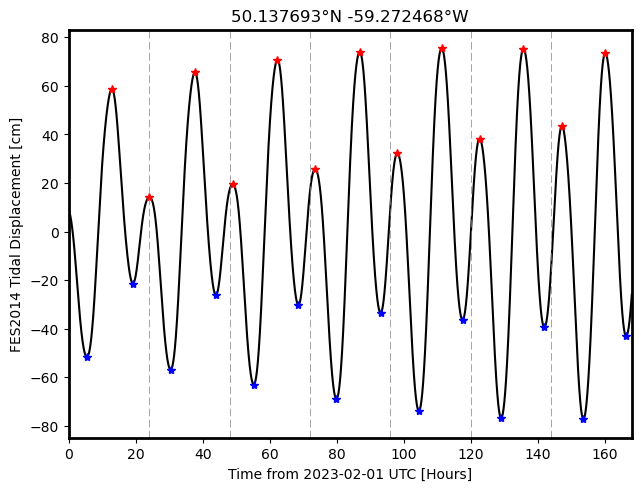

In [4]:
#%matplotlib widget

# get model parameters
model = pyTMD.io.model(TMDwidgets.directory.value,
    format=TMDwidgets.atlas.value,
    compressed=TMDwidgets.compress.value
   ).elevation(TMDwidgets.model.value)

# convert from calendar date to days relative to Jan 1, 1992 (48622 MJD)
YMD = TMDwidgets.datepick.value
# calculate a weeks forecast every minute
minutes = np.arange(7*1440)
# convert time from MJD to days relative to Jan 1, 1992 (48622 MJD)
tide_time = pyTMD.time.convert_calendar_dates(YMD.year, YMD.month,
    YMD.day, minute=minutes)
hours = minutes/60.0

# create plot with tidal displacements, high and low tides and dates
fig,ax1 = plt.subplots(num=1)
xmax = np.ceil(hours[-1]).astype('i')
l1, = ax1.plot([], [], 'k')
l2, = ax1.plot([], [], 'r*')
l3, = ax1.plot([], [], 'b*')
for h in range(24,xmax,24):
    ax1.axvline(h,color='gray',lw=0.5,ls='dashed',dashes=(11,5))
ax1.set_xlim(0,xmax)
ax1.set_ylabel(f'{model.name} Tidal Displacement [cm]')
args = (YMD.year,YMD.month,YMD.day)
ax1.set_xlabel('Time from {0:4d}-{1:02d}-{2:02d} UTC [Hours]'.format(*args))
ttl = ax1.set_title(None)
fig.subplots_adjust(left=0.10,right=0.98,bottom=0.10,top=0.95)

# delta time (TT - UT1) file
delta_file = pyTMD.utilities.get_data_path(['data','merged_deltat.data'])

# read tidal constants and interpolate to leaflet points
if model.format in ('OTIS','ATLAS','ESR'):
    constituents = pyTMD.io.OTIS.read_constants(
        model.grid_file, model.model_file,
        model.projection, type=model.type,
        grid=model.format)
    c = constituents.fields
    DELTAT = np.zeros_like(tide_time)
elif (model.format == 'netcdf'):
    constituents = pyTMD.io.ATLAS.read_constants(
        model.grid_file, model.model_file,
        type=model.type, compressed=model.compressed)
    c = constituents.fields
    DELTAT = np.zeros_like(tide_time)
elif (model.format == 'GOT'):
    constituents = pyTMD.io.GOT.read_constants(
        model.model_file, compressed=model.compressed)
    c = constituents.fields
    # interpolate delta times from calendar dates to tide time
    DELTAT = pyTMD.time.interpolate_delta_time(delta_file, tide_time)
elif (model.format == 'FES'):
    constituents = pyTMD.io.FES.read_constants(model.model_file,
        type=model.type, version=model.version,
        compressed=model.compressed)
    c = model.constituents
    # interpolate delta times from calendar dates to tide time
    DELTAT = pyTMD.time.interpolate_delta_time(delta_file, tide_time)
    
# update the tide prediction and plot
def update_tide_prediction(*args):
    # leaflet location
    LAT,LON = np.copy(m.marker.location)
    # verify longitudes
    LON = m.wrap_longitudes(LON)
    if model.format in ('OTIS','ATLAS','ESR'):
        amp,ph,D = pyTMD.io.OTIS.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, model.projection, type=model.type,
            method='spline', extrapolate=True)
    elif (model.format == 'netcdf'):
        amp,ph,D = pyTMD.io.ATLAS.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, type=model.type, scale=model.scale,
            method='spline', extrapolate=True)
    elif (model.format == 'GOT'):
        amp,ph = pyTMD.io.GOT.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, scale=model.scale,
            method='spline', extrapolate=True)
    elif (model.format == 'FES'):
        amp,ph = pyTMD.io.FES.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, scale=model.scale,
            method='spline', extrapolate=True)
    # calculate complex phase in radians for Euler's
    cph = -1j*ph*np.pi/180.0
    # calculate constituent oscillation
    hc = amp*np.exp(cph)
    # predict tidal elevations at time 1 and infer minor corrections
    TIDE = pyTMD.predict.time_series(tide_time, hc, c,
        deltat=DELTAT, corrections=model.format)
    MINOR = pyTMD.predict.infer_minor(tide_time, hc, c,
        deltat=DELTAT, corrections=model.format)
    TIDE.data[:] += MINOR.data[:]
    # convert to centimeters
    TIDE.data[:] *= 100.0

    # differentiate to calculate high and low tides
    diff = np.zeros_like(tide_time, dtype=np.float64)
    # forward differentiation for starting point
    diff[0] = TIDE.data[1] - TIDE.data[0]
    # backward differentiation for end point
    diff[-1] = TIDE.data[-1] - TIDE.data[-2]
    # centered differentiation for all others
    diff[1:-1] = (TIDE.data[2:] - TIDE.data[0:-2])/2.0
    # indices of high and low tides
    htindex, = np.nonzero((np.sign(diff[0:-1]) >= 0) & (np.sign(diff[1:]) < 0))
    ltindex, = np.nonzero((np.sign(diff[0:-1]) <= 0) & (np.sign(diff[1:]) > 0))
    # update plot data
    l1.set_data(hours, TIDE.data)
    l2.set_data(hours[htindex], TIDE.data[htindex])
    l3.set_data(hours[ltindex], TIDE.data[ltindex])
    # update plot title
    ttl.set_text(u'{0:0.6f}\u00b0N {1:0.6f}\u00b0W'.format(LAT,LON))
    ax1.relim()
    ax1.autoscale_view()
    fig.canvas.draw()

# run tide prediction at initial location
update_tide_prediction()
# watch marker location for changes
m.marker_text.observe(update_tide_prediction)